<a href="https://colab.research.google.com/github/sharnika1215/2025-uom-ai-session/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d yasserh/housing-prices-dataset


Dataset URL: https://www.kaggle.com/datasets/yasserh/housing-prices-dataset
License(s): CC0-1.0
  0% 0.00/4.63k [00:00<?, ?B/s]
100% 4.63k/4.63k [00:00<00:00, 12.2MB/s]


In [5]:
!unzip housing-prices-dataset.zip


Archive:  housing-prices-dataset.zip
  inflating: Housing.csv             


In [6]:
import pandas as pd

# adjust file name if necessary (Housing.csv or housing.csv)
df = pd.read_csv("Housing.csv")
df.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [10]:
# House price prediction — notebook/script
# Tested with: python 3.9+, pandas, scikit-learn, xgboost, joblib

# 1) Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import xgboost as xgb

# 2) Load data
df = pd.read_csv("Housing.csv")
print("Shape:", df.shape)
display(df.head())

# 3) Quick EDA (adjust depending on dataset columns)
print("Columns:", df.columns.tolist())
print("Missing per column:\n", df.isnull().sum().sort_values(ascending=False).head(20))
print("Target stats (price if column name 'price'):")
if 'price' in df.columns:
    print(df['price'].describe())
else:
    raise ValueError("No 'price' column found — update the target column name in the script.")

# 4) Feature selection
# For small datasets pick a subset of sensible features. Modify this list according to CSV columns.
# Example common features:
features = [c for c in df.columns if c != 'price']
# You can customize like:
# features = ['area', 'bedrooms', 'bathrooms', 'furnished', 'mainroad', 'guestroom', 'parking']

X = df[features].copy()
y = df['price'].copy()

# 5) Separate numerical and categorical columns
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
print("Numerical cols:", num_cols)
print("Categorical cols:", cat_cols)

# 6) Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For low-cardinality categoricals: OneHot; for high-cardinality, Ordinal or Target encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

# 7) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8) Model pipelines (RandomForest and XGBoost)
rf_pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

xgb_pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# 9) Quick baseline training (RandomForest)
print("Training RandomForest...")
rf_pipeline.fit(X_train, y_train)

# 10) Evaluation helper
def evaluate(model, X_tr, X_te, y_tr, y_te):
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    metrics = {}
    for name, y_true, y_pred in [
        ('train', y_tr, y_pred_train), ('test', y_te, y_pred_test)
    ]:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        metrics[name] = {'rmse': rmse, 'mae': mae, 'r2': r2}
    return metrics

rf_metrics = evaluate(rf_pipeline, X_train, X_test, y_train, y_test)
print("RandomForest metrics:", rf_metrics)

# 11) Train XGBoost quickly and evaluate
print("Training XGBoost...")
xgb_pipeline.fit(X_train, y_train)
xgb_metrics = evaluate(xgb_pipeline, X_train, X_test, y_train, y_test)
print("XGBoost metrics:", xgb_metrics)

# 12) Cross-validation (optional)
cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
print("RF CV RMSE scores (neg):", cv_scores)
print("RF CV RMSE mean:", -cv_scores.mean())

# 13) Hyperparameter tuning example (small grid)
param_grid = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [None, 10, 20]
}
gs = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best_model = gs.best_estimator_
print("Tuned RF metrics:", evaluate(best_model, X_train, X_test, y_train, y_test))

# 14) Save final model
joblib.dump(best_model, "house_price_model_rf.joblib")
print("Saved model to house_price_model_rf.joblib")

# 15) Example prediction on new samples:
sample = X_test.iloc[:5]
preds = best_model.predict(sample)
print("Sample predictions:", preds)
print("Actual:", y_test.iloc[:5].values)

Shape: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


Columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']
Missing per column:
 price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64
Target stats (price if column name 'price'):
count    5.450000e+02
mean     4.766729e+06
std      1.870440e+06
min      1.750000e+06
25%      3.430000e+06
50%      4.340000e+06
75%      5.740000e+06
max      1.330000e+07
Name: price, dtype: float64
Numerical cols: ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorical cols: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
Training RandomForest...
RandomForest metrics: {'tra

In [11]:
from google.colab import files
files.download("house_price_model_rf.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

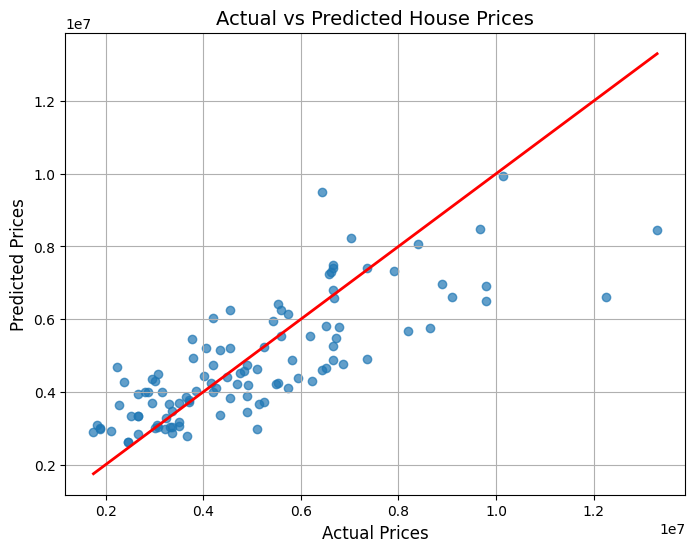

In [12]:
import matplotlib.pyplot as plt

# Use the best model from before
y_pred = best_model.predict(X_test)

# Create a scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Actual vs Predicted House Prices", fontsize=14)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linewidth=2)  # perfect prediction line
plt.grid(True)
plt.show()
